# Large-scale models and simulation methods - Project

## Data:

[INSEE CENSUS](https://www.insee.fr/fr/statistiques/fichier/6544333/RP2019_INDCVIZB_csv.zip)

[IGN](https://data.geopf.fr/telechargement/download/CONTOURS-IRIS/CONTOURS-IRIS_2-1__SHP__FRA_2021-01-01/CONTOURS-IRIS_2-1__SHP__FRA_2021-01-01.7z)

[INSEE AGGREGATED](https://www.insee.fr/fr/statistiques/fichier/6543200/base-ic-evol-struct-pop-2019_csv.zip)

[URSSAF](https://open.urssaf.fr/api/explore/v2.1/catalog/datasets/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B)

[MOBPRO](https://www.insee.fr/fr/statistiques/fichier/6456056/RP2019_mobpro_csv.zip)


In [36]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [37]:
# import os

# chemin = "/content/drive/MyDrive/"

# print(os.listdir(chemin))

In [38]:
# ! pip install osmnx==1.1.2
# !pip install pyrosm

In [39]:
from pathlib import Path
from sys import exit

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from numpy.linalg import norm
from shapely.geometry import LineString

# import pyrosm

In [40]:
DATA_FOLDER = Path("./raw_data/")
CENSUS_DATA = DATA_FOLDER / "FD_INDCVIZB_2019.csv"
IRIS_DATA = DATA_FOLDER / "CONTOURS-IRIS.shp"
POULATION_DATA = DATA_FOLDER / "base-ic-evol-struct-pop-2019.CSV"
EMPLOYMENT_DATA = (
    DATA_FOLDER
    / "etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv"
)
COMMUTES_DATA = DATA_FOLDER / "FD_MOBPRO_2019.csv"

print("DATA_FOLDER:", DATA_FOLDER)

if not DATA_FOLDER.exists():
    print("Creating data folder...")
    DATA_FOLDER.mkdir()
if not CENSUS_DATA.exists():
    print(f"CENSUS data is missing! Please add: {CENSUS_DATA}")
    exit()
if not IRIS_DATA.exists():
    print(f"IRIS data is missing! Please add: {IRIS_DATA}")
    exit()
if not POULATION_DATA.exists():
    print(f"POPULATION data is missing! Please add: {POULATION_DATA}")
    exit()
if not EMPLOYMENT_DATA.exists():
    print(f"EMPLOYMENT data is missing! Please add: {EMPLOYMENT_DATA}")
    exit()
if not COMMUTES_DATA.exists():
    print(f"COMMUTES data is missing! Please add: {COMMUTES_DATA}")
    exit()

DATA_FOLDER: raw_data


In [41]:
# Census data

columns = {
    "IRIS": str,
    "IPONDI": float,
    "AGED": int,
    "CS1": int,
    "DEPT": int,
}

df_census = pd.read_csv(CENSUS_DATA, sep=";", dtype=columns, usecols=columns.keys())
df_census = df_census.rename(
    columns={
        "IRIS": "iris_id",
        "IPONDI": "weight",
        "AGED": "age",
        "CS1": "csp",
        "DEPT": "department",
    }
)
df_census = df_census[df_census["department"] == 14]
df_census = df_census.drop(columns=["department"])

print(df_census["iris_id"].str[:2].unique())

df_census["department_id"] = df_census["iris_id"].str[:2]
df_census["municipality_id"] = df_census["iris_id"].str[:5]

municipalities_in_department = df_census["municipality_id"].unique()

print(municipalities_in_department)

print(df_census.head())
print(df_census.describe())
print(df_census.info())

# Export to CSV
# df_census.to_csv(DATA_FOLDER / "exported" / "census.csv", index=False)

['ZZ' '14']
['ZZZZZ' '14047' '14225' '14271' '14174' '14258' '14167' '14327' '14715'
 '14333' '14301' '14341' '14437' '14181' '14366' '14488' '14762' '14118']
        age  csp    weight    iris_id department_id municipality_id
135714   92    7  5.000000  ZZZZZZZZZ            ZZ           ZZZZZ
135715   72    7  5.120056  ZZZZZZZZZ            ZZ           ZZZZZ
135716   70    7  5.120056  ZZZZZZZZZ            ZZ           ZZZZZ
135717   32    5  5.161397  ZZZZZZZZZ            ZZ           ZZZZZ
135718   27    6  5.161397  ZZZZZZZZZ            ZZ           ZZZZZ
                 age            csp         weight
count  171834.000000  171834.000000  171834.000000
mean       42.189532       6.183823       4.045367
std        24.332975       1.786532       1.365502
min         0.000000       1.000000       0.500003
25%        21.000000       5.000000       3.157650
50%        42.000000       7.000000       4.915419
75%        62.000000       8.000000       5.013655
max       117.000000     

In [42]:
# Iris data

df_iris: gpd.GeoDataFrame = gpd.read_file(IRIS_DATA)
df_iris = df_iris.rename(
    columns={
        "INSEE_COM": "municipality_id",
        "CODE_IRIS": "iris_id",
    }
)[["iris_id", "municipality_id", "geometry"]]
df_iris["department_id"] = df_iris["iris_id"].str[:2]

print(df_iris.head())
print(df_iris.describe())
print(df_iris.info())

# df_iris.to_csv(DATA_FOLDER / "exported" / "iris.csv", index=False)

     iris_id municipality_id  \
0  721910000           72191   
1  772480000           77248   
2  514260000           51426   
3  811990000           81199   
4  592250102           59225   

                                            geometry department_id  
0  POLYGON ((498083.5 6747517.4, 498128 6747467.1...            72  
1  POLYGON ((685753.1 6868612.9, 685757.7 6868592...            77  
2  POLYGON ((759067.2 6849592.7, 758778.6 6849650...            51  
3  POLYGON ((651482.8 6326359.4, 651475.6 6326359...            81  
4  POLYGON ((767673.5 7022290.5, 767647.2 7022275...            59  
          iris_id municipality_id  \
count       48589           48589   
unique      48589           34878   
top     721910000           31555   
freq            1             153   

                                                 geometry department_id  
count                                               48589         48589  
unique                                              48589  

In [43]:
# Population data

columns = ["COM", "C19_POP15P"]
columns += ["C19_POP15P_CS{}".format(k) for k in range(1, 9)]

df_population = pd.read_csv(
    POULATION_DATA,
    sep=";",
    usecols=columns,
    dtype={"COM": str},
)

renamed_columns = ["municipality_id", "population"]
renamed_columns += ["csp_{}".format(k) for k in range(1, 9)]
df_population.columns = renamed_columns

df_population = df_population.groupby("municipality_id").sum().reset_index()

df_population = df_population[
    df_population["municipality_id"].isin(municipalities_in_department)
]

print(df_population.head())
print(df_population.describe())
print(df_population.info())

# df_population.to_csv(DATA_FOLDER / "exported" / "population.csv", index=False)

     municipality_id    population      csp_1        csp_2         csp_3  \
4463           14047  10866.236734  29.555389   309.798099    605.095392   
4511           14118  92552.390879  66.199198  1977.851887  10193.275461   
4544           14167   5699.378238   5.376894    62.744118    264.518180   
4550           14174   5474.754555  95.816437   166.495040    132.849427   
4555           14181   4161.497246   5.021490    85.567871    242.626643   

             csp_4         csp_5        csp_6         csp_7         csp_8  
4463   1317.364554   1711.049241  1473.201324   4050.169144   1370.003592  
4511  12527.463372  13525.284919  7392.327129  20724.561628  26145.427286  
4544    629.019630   1178.845039  1058.223773   1661.189338    839.461267  
4550    566.560735    618.738692  1078.548952   2163.578090    652.167181  
4555    530.509584    733.771661   444.882705   1519.301011    599.816281  
         population       csp_1        csp_2         csp_3         csp_4  \
count     1

In [44]:
# Employment data

df_employment = pd.read_csv(
    EMPLOYMENT_DATA,
    sep=";",
    usecols=["Code commune", "Effectifs salariés 2019"],
    dtype={"Code commune": str},
)

df_employment = df_employment.rename(
    columns={"Code commune": "municipality_id", "Effectifs salariés 2019": "employment"}
)

df_employment = df_employment.groupby("municipality_id").sum().reset_index()

df_employment = df_employment[
    df_employment["municipality_id"].isin(municipalities_in_department)
]

print(df_employment.head())
print(df_employment.describe())
print(df_employment.info())

# df_employment.to_csv(DATA_FOLDER / "exported" / "employment.csv", index=False)

     municipality_id  employment
4213           14047      4582.0
4260           14118     35334.0
4292           14167      4473.0
4298           14174      2359.0
4303           14181      3630.0
         employment
count     17.000000
mean    6434.470588
std     8084.492015
min     1581.000000
25%     2248.000000
50%     3630.000000
75%     8298.000000
max    35334.000000
<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 4213 to 4692
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   municipality_id  17 non-null     object 
 1   employment       17 non-null     float64
dtypes: float64(1), object(1)
memory usage: 408.0+ bytes
None


In [45]:
# Commutes data

columns = {"COMMUNE": str, "ARM": str, "DCLT": str, "IPONDI": float, "TRANS": int}
df_commutes = pd.read_csv(COMMUTES_DATA, dtype=columns, usecols=columns.keys(), sep=";")

f = df_commutes["ARM"] != "ZZZZZ"
df_commutes.loc[f, "COMMUNE"] = df_commutes.loc[f, "ARM"]

df_commutes = df_commutes.rename(
    columns={
        "COMMUNE": "origin_id",
        "DCLT": "destination_id",
        "IPONDI": "weight",
        "TRANS": "transport_mode",
    }
)[["origin_id", "destination_id", "weight", "transport_mode"]]

df_commutes = df_commutes[
    df_commutes["origin_id"].str[:2].isin(["14"])
    & df_commutes["destination_id"].str[:2].isin(["14"])
]

df_commutes = (
    df_commutes.groupby(["origin_id", "destination_id"])["weight"].sum().reset_index()
)

print(df_commutes.head())
print(df_commutes.describe())
print(df_commutes.info())

# df_commutes.to_csv(DATA_FOLDER / "exported" / "commutes.csv", index=False)

  origin_id destination_id     weight
0     14001          14001  91.647616
1     14001          14047   5.057447
2     14001          14077   5.118085
3     14001          14083   4.997528
4     14001          14102   5.118085
             weight
count   9866.000000
mean      25.871578
std      262.085838
min        0.631857
25%        5.000000
50%        5.222222
75%       15.000000
max    23873.400989
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9866 entries, 0 to 9865
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   origin_id       9866 non-null   object 
 1   destination_id  9866 non-null   object 
 2   weight          9866 non-null   float64
dtypes: float64(1), object(2)
memory usage: 231.4+ KB
None


## Exercise 1.1: Study area


### (1) How many person observations are included in the census for that department?


In [46]:
observations = len(df_census)
print(f"Number of observations: {observations}")

Number of observations: 171834


### (2) How many persons live in that department?


In [47]:
people = df_census["weight"].sum()
print(f"Number of people: {people}")

Number of people: 695131.5553559497


### (3) How many municipalities are there in the department?


In [48]:
print(f"Municipalities: {municipalities_in_department}")
print(f"Number of municipalities: {municipalities_in_department.size}")

Municipalities: ['ZZZZZ' '14047' '14225' '14271' '14174' '14258' '14167' '14327' '14715'
 '14333' '14301' '14341' '14437' '14181' '14366' '14488' '14762' '14118']
Number of municipalities: 18


### Prepare a map that shows where the department is located inside of France.


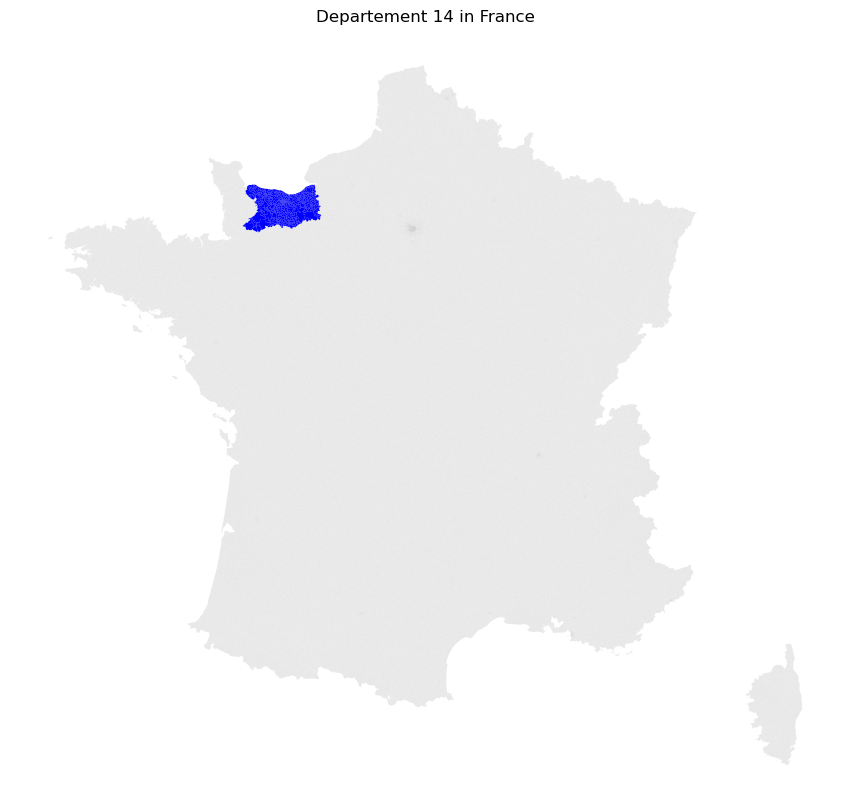

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))
df_iris.plot(ax=ax, color="lightgrey", alpha=0.5)
df_iris[df_iris["department_id"] == "14"].plot(
    ax=ax,
    color="blue",
)

ax.set_title("Departement 14 in France")
ax.axis("off")

plt.show()

## Exercise 1.2: Territorial analysis I


### Plot the age distribution of the persons living in the department. Indicate the average age of persons living in the territory.


In [50]:
weighted_counts = (
    df_census.groupby("age")["weight"]
    .sum()
    .reset_index()
    .rename(columns={"weight": "weighted_count"})
)

weighted_avg_age = (
    weighted_counts["age"] * weighted_counts["weighted_count"]
).sum() / weighted_counts["weighted_count"].sum()

fig = px.bar(
    weighted_counts,
    x="age",
    y="weighted_count",
    title="Age Distribution",
)
fig.add_vline(
    x=weighted_avg_age,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Avg. age: {weighted_avg_age:.2f}",
    annotation_position="top",
)
fig.show()

print(f"Avg. age: {weighted_avg_age:.2f}")

Avg. age: 43.00


### Make a map of the municipalities in the study area and indicate the average age of their population. Which municipality is the youngest, which one is the oldest?


0        True
1        True
2        True
3        True
4        True
         ... 
34873    True
34874    True
34875    True
34876    True
34877    True
Length: 34878, dtype: bool


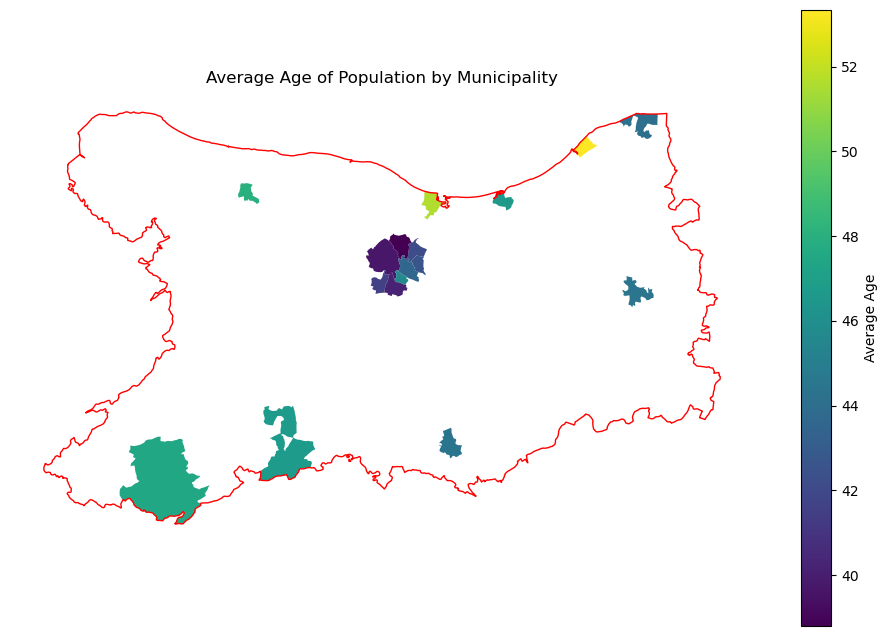

Youngest Municipality: ID 14327 with Avg Age 38.80
Oldest Municipality: ID 14715 with Avg Age 53.34


In [51]:
df_iris_14 = df_iris[df_iris["department_id"] == "14"]
department_boundary = df_iris_14.dissolve(by="department_id")

spatial_municipalities = df_iris.dissolve(by="municipality_id").reset_index()
print(spatial_municipalities.is_valid)

df_census_grouped = (
    df_census.groupby("municipality_id")
    .agg(
        total_weight=("weight", "sum"),
        avg_age=(
            "age",
            lambda x: np.average(x, weights=df_census.loc[x.index, "weight"]),
        ),
    )
    .reset_index()
)

spatial_data = spatial_municipalities.merge(
    df_census_grouped, on="municipality_id", how="left"
)

fig, ax = plt.subplots(figsize=(12, 8))
spatial_data.plot(
    column="avg_age",
    cmap="viridis",
    legend=True,
    ax=ax,
    legend_kwds={"label": "Average Age"},
)
ax.set_title("Average Age of Population by Municipality")
ax.set_axis_off()
department_boundary.plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=1, label="Department Boundary"
)

plt.show()

youngest = spatial_data.loc[spatial_data["avg_age"].idxmin()]
oldest = spatial_data.loc[spatial_data["avg_age"].idxmax()]
print(
    f"Youngest Municipality: ID {youngest['municipality_id']} with Avg Age {youngest['avg_age']:.2f}"
)
print(
    f"Oldest Municipality: ID {oldest['municipality_id']} with Avg Age {oldest['avg_age']:.2f}"
)

In [52]:
missing_municipalities = set(df_census_grouped["municipality_id"]) - set(
    df_iris["municipality_id"]
)
print(f"Missing municipalities: {missing_municipalities}")

Missing municipalities: {'ZZZZZ'}


In [53]:
print(df_population.head())

     municipality_id    population      csp_1        csp_2         csp_3  \
4463           14047  10866.236734  29.555389   309.798099    605.095392   
4511           14118  92552.390879  66.199198  1977.851887  10193.275461   
4544           14167   5699.378238   5.376894    62.744118    264.518180   
4550           14174   5474.754555  95.816437   166.495040    132.849427   
4555           14181   4161.497246   5.021490    85.567871    242.626643   

             csp_4         csp_5        csp_6         csp_7         csp_8  
4463   1317.364554   1711.049241  1473.201324   4050.169144   1370.003592  
4511  12527.463372  13525.284919  7392.327129  20724.561628  26145.427286  
4544    629.019630   1178.845039  1058.223773   1661.189338    839.461267  
4550    566.560735    618.738692  1078.548952   2163.578090    652.167181  
4555    530.509584    733.771661   444.882705   1519.301011    599.816281  


### Plot the distribution of socio-professional categories of the overall study area and for at least three individual municipalities. Describe if you see differences between municipalities and the study area in general.


In [54]:
def plot_csp_distribution(df_census: pd.DataFrame, title: str = "CSP Distribution"):
    df_csp = df_census.groupby("csp")["weight"].sum().reset_index()

    df_csp["csp"] = df_csp["csp"].replace(
        {
            1: "Agriculteurs",
            2: "Artisans",
            3: "Cadres",
            4: "Intermédiaires",
            5: "Employés",
            6: "Ouvriers",
            7: "Retraités",
            8: "Autres",
        }
    )

    fig = px.histogram(df_csp, x="csp", y="weight", title=title).update_xaxes(
        categoryorder="total descending"
    )
    fig.show()


plot_csp_distribution(
    df_census,
    title="CSP Distribution - Departement '14'",
)
for municipality_id in df_census["municipality_id"].unique():
    plot_csp_distribution(
        df_census[df_census["municipality_id"] == municipality_id],
        title=f"CSP Distribution - Municipality '{municipality_id}'",
    )

## Exercise 1.3: Territorial analysis II


### Create a bar plot indicating the number of working inhabitants in each municipality.


In [55]:
working_csp = [1, 2, 3, 4, 5, 6]
df_working = df_census[df_census["csp"].isin(working_csp)]
df_working = df_working[df_working["municipality_id"] != "ZZZZZ"]

working_by_municipality = (
    df_working.groupby("municipality_id")["weight"]
    .sum()
    .reset_index()
    .rename(columns={"weight": "working_population"})
)

fig = px.bar(
    working_by_municipality,
    x="municipality_id",
    y="working_population",
    title="Working Population by Municipality",
).update_xaxes(categoryorder="total descending")
fig.show()

### Create a bar plot indicating the number of employees in each municipality


In [56]:
fig = px.bar(
    df_employment,
    x="municipality_id",
    y="employment",
    title="Number of Employees by Municipality",
).update_xaxes(categoryorder="total descending")
fig.show()

### Make a map of the study area which, for each municipality, shows the difference between working inhabitants and employees. Which municipality the largest net outflow (inhabitants - employees), which one the largest net inflow of employees?


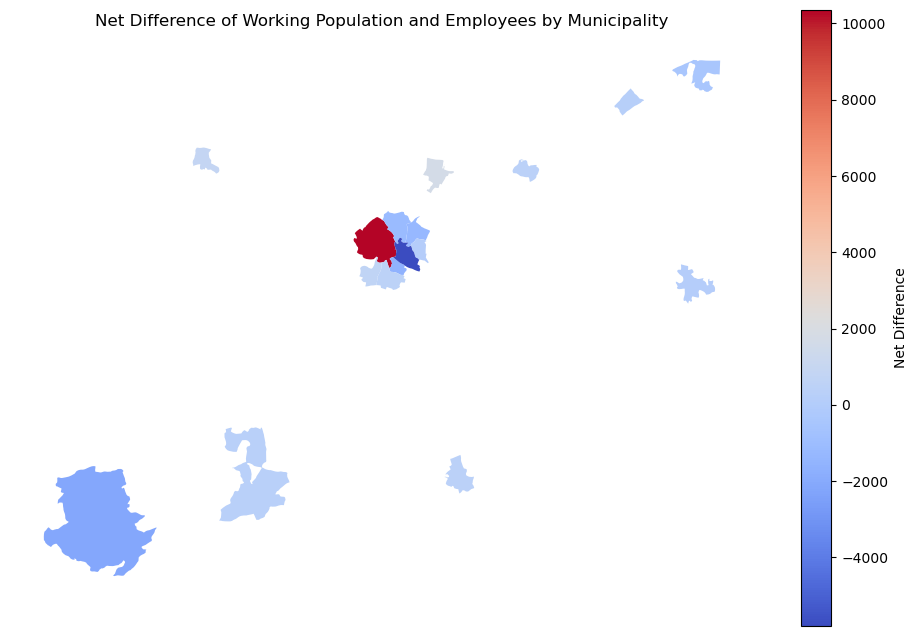

Largest Deficit Municipality: ID 14437 with Net Difference -5795.9153782396
Largest Surplus Municipality: ID 14118 with Net Difference 10351.566778857981


In [57]:
df_combined = df_employment.merge(working_by_municipality, on="municipality_id")
df_combined["net_difference"] = (
    df_combined["working_population"] - df_combined["employment"]
)

spatial_data = spatial_municipalities.merge(
    df_combined, on="municipality_id", how="left"
)
fig, ax = plt.subplots(figsize=(12, 8))
spatial_data.plot(
    column="net_difference",
    cmap="coolwarm",
    legend=True,
    ax=ax,
    legend_kwds={"label": "Net Difference"},
)
ax.set_title("Net Difference of Working Population and Employees by Municipality")
ax.set_axis_off()

plt.show()

largest_deficit = spatial_data.loc[spatial_data["net_difference"].idxmin()]
largest_surplus = spatial_data.loc[spatial_data["net_difference"].idxmax()]

print(
    f"Largest Deficit Municipality: ID {largest_deficit['municipality_id']} with Net Difference {largest_deficit['net_difference']}"
)
print(
    f"Largest Surplus Municipality: ID {largest_surplus['municipality_id']} with Net Difference {largest_surplus['net_difference']}"
)

In [58]:
print(df_population.head())

     municipality_id    population      csp_1        csp_2         csp_3  \
4463           14047  10866.236734  29.555389   309.798099    605.095392   
4511           14118  92552.390879  66.199198  1977.851887  10193.275461   
4544           14167   5699.378238   5.376894    62.744118    264.518180   
4550           14174   5474.754555  95.816437   166.495040    132.849427   
4555           14181   4161.497246   5.021490    85.567871    242.626643   

             csp_4         csp_5        csp_6         csp_7         csp_8  
4463   1317.364554   1711.049241  1473.201324   4050.169144   1370.003592  
4511  12527.463372  13525.284919  7392.327129  20724.561628  26145.427286  
4544    629.019630   1178.845039  1058.223773   1661.189338    839.461267  
4550    566.560735    618.738692  1078.548952   2163.578090    652.167181  
4555    530.509584    733.771661   444.882705   1519.301011    599.816281  


## Exercise 2.1: Trip production

### Apply the model to your study area and solve the following tasks:


In [59]:
df_population = (
    df_population.set_index("municipality_id")
    .reindex(municipalities_in_department)
    .reset_index()
    .fillna(0)
)

df_origins = df_commutes.groupby("origin_id")["weight"].sum().reset_index()
df_origins = (
    df_origins.set_index("origin_id")
    .reindex(municipalities_in_department)
    .reset_index()
    .fillna(0)
)

O = df_origins["weight"].values
N = df_population["population"].values

nominator = np.sum(O * N)
denominator = np.sum(N**2)

beta = nominator / denominator
beta

print(df_population.head())

  municipality_id    population      csp_1       csp_2       csp_3  \
0           ZZZZZ      0.000000   0.000000    0.000000    0.000000   
1           14047  10866.236734  29.555389  309.798099  605.095392   
2           14225   4485.000000  10.000000  150.000000  125.000000   
3           14271   4142.519175   5.006098  125.932368  321.592176   
4           14174   5474.754555  95.816437  166.495040  132.849427   

         csp_4        csp_5        csp_6        csp_7        csp_8  
0     0.000000     0.000000     0.000000     0.000000     0.000000  
1  1317.364554  1711.049241  1473.201324  4050.169144  1370.003592  
2   405.000000   715.000000   735.000000  1610.000000   735.000000  
3   545.984857   842.593440   598.902214  1107.937635   594.570387  
4   566.560735   618.738692  1078.548952  2163.578090   652.167181  


In [60]:
print(beta)

0.389544834194181


### Report how many trips have been generated in total.


In [61]:
# Model parameters
beta_0 = 27.244
beta_coeffs = [0.319, 0.994, 0.863, 0.990, 0.780, 0.708, 0.120, -0.073]

trip_generation = []
for _, row in df_population.iterrows():
    weighted_sum = sum(
        row[f"csp_{i+1}"] * beta_coeffs[i] for i in range(len(beta_coeffs))
    )
    trips = max(beta_0 + weighted_sum, 0)
    trip_generation.append(trips)

df_population["generated_trips"] = trip_generation

total_trips = df_population["generated_trips"].sum()
print(f"Total trips generated: {total_trips}")

Total trips generated: 98841.5523660502


### Report using a bar plot how many trips have been generated for each SPC in the study area.


In [62]:
csp_labels = [
    "Agriculteurs",
    "Artisans",
    "Cadres",
    "Intermédiaires",
    "Employés",
    "Ouvriers",
    "Retraités",
    "Autres",
]

csp_trips = []
for i, beta in enumerate(beta_coeffs):
    total_trips = (df_population[f"csp_{i+1}"] * beta).sum()
    total_trips = max(total_trips, 0)
    csp_trips.append(total_trips)

df_csp_trips = pd.DataFrame({"CSP": csp_labels, "Generated_Trips": csp_trips})

fig = px.bar(
    df_csp_trips,
    x="CSP",
    y="Generated_Trips",
    title="Trips Generated by Socio-Professional Category (CSP)",
    labels={"Generated_Trips": "Trips"},
    text="Generated_Trips",
)
fig.update_traces(texttemplate="%{text:.2f}", textposition="outside")
fig.update_layout(xaxis_title="CSP", yaxis_title="Generated Trips")
fig.show()

### On a map, show the total number of trips generated per IRIS.


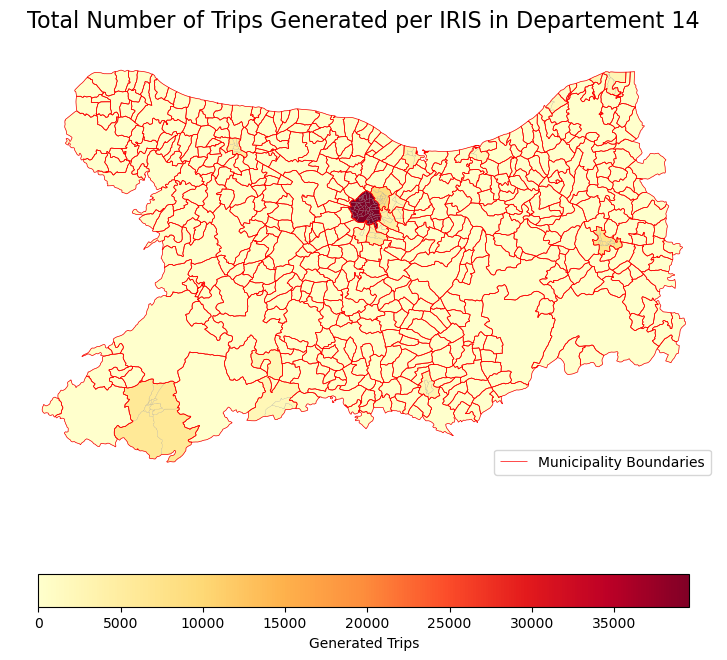

In [63]:
df_iris_trips_14 = df_iris_14.merge(
    df_population[["municipality_id", "generated_trips"]],
    on="municipality_id",
    how="left",
)

df_iris_trips_14["generated_trips"] = df_iris_trips_14["generated_trips"].fillna(0)
municipalities_boundary = df_iris_14.dissolve(by="municipality_id")

fig, ax = plt.subplots(figsize=(12, 8))
df_iris_trips_14.plot(
    column="generated_trips",
    cmap="YlOrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={
        "label": "Generated Trips",
        "orientation": "horizontal",
        "shrink": 0.7,
    },
    ax=ax,
)

municipalities_boundary.boundary.plot(
    ax=ax, color="red", linewidth=0.5, label="Municipality Boundaries"
)

ax.set_title("Total Number of Trips Generated per IRIS in Departement 14", fontsize=16)
ax.axis("off")
plt.legend(loc="lower right")
plt.show()

## Exercise 2.2: Trip attraction


### Report on the value of N that you have chosen. Plot on a map how many arriving trips have been generated for each municipality in the study area.


Value of N: 69189.08665623513


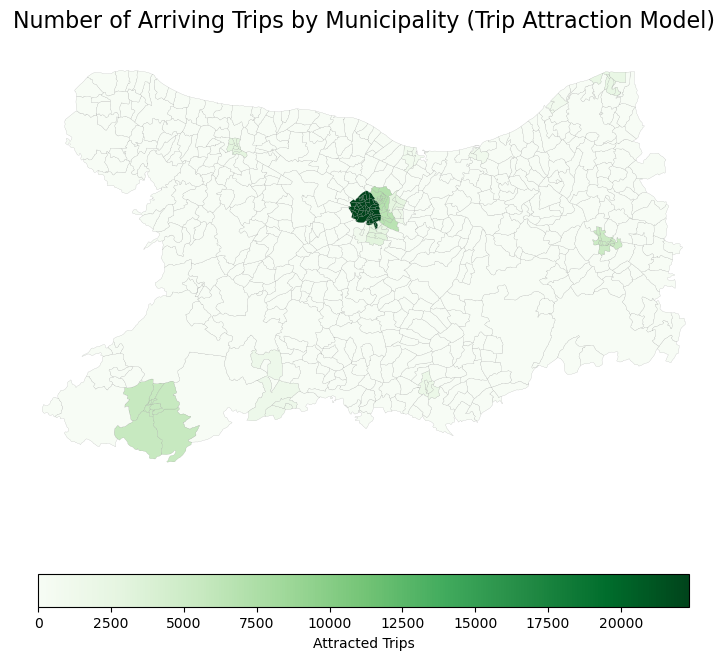

In [64]:
total_employment = df_employment["employment"].sum()
total_generated_trips = df_population["generated_trips"].sum()

N = min(0.7 * total_employment, 0.7 * total_generated_trips)
print(f"Value of N: {N}")

df_employment["attracted_trips"] = (df_employment["employment"] / total_employment) * N

df_iris_attraction = df_iris_14.merge(
    df_employment[["municipality_id", "attracted_trips"]],
    on="municipality_id",
    how="left",
)

df_iris_attraction["attracted_trips"] = df_iris_attraction["attracted_trips"].fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
df_iris_attraction.plot(
    column="attracted_trips",
    cmap="Greens",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={
        "label": "Attracted Trips",
        "orientation": "horizontal",
        "shrink": 0.7,
    },
    ax=ax,
)
ax.set_title(
    "Number of Arriving Trips by Municipality (Trip Attraction Model)", fontsize=16
)
ax.axis("off")
plt.show()

### Proportionately scale your demand per zone from Exercise 2.1


In [65]:
total_generated_trips = df_population["generated_trips"].sum()

df_population["adjusted_generated_trips"] = df_population["generated_trips"] * (
    N / total_generated_trips
)

adjusted_total_generated_trips = df_population["adjusted_generated_trips"].sum()
print(f"Adjusted total generated trips: {adjusted_total_generated_trips}")

Adjusted total generated trips: 69189.08665623514


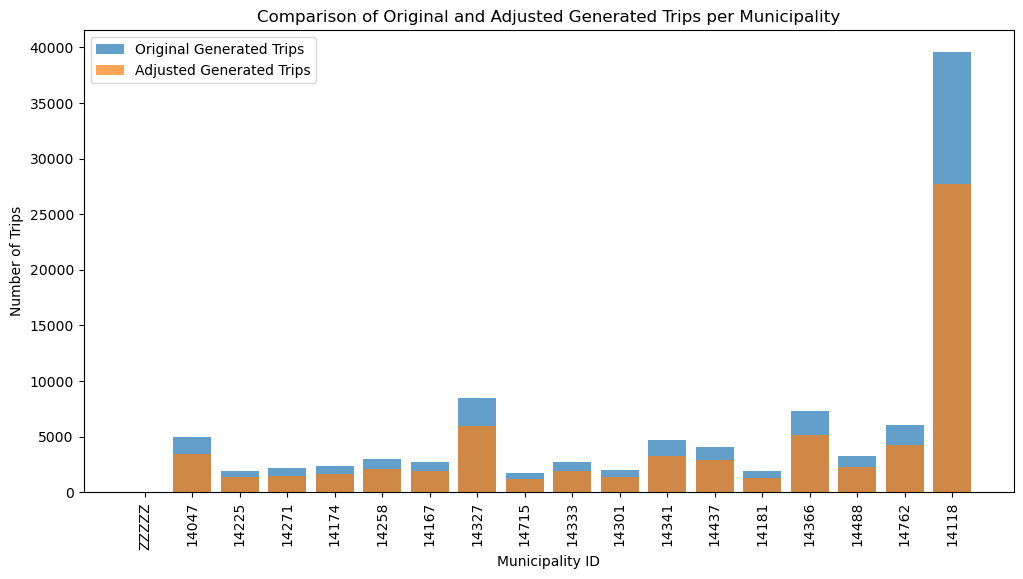

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    df_population["municipality_id"],
    df_population["generated_trips"],
    label="Original Generated Trips",
    alpha=0.7,
)
ax.bar(
    df_population["municipality_id"],
    df_population["adjusted_generated_trips"],
    label="Adjusted Generated Trips",
    alpha=0.7,
)
ax.set_title("Comparison of Original and Adjusted Generated Trips per Municipality")
ax.set_xlabel("Municipality ID")
ax.set_ylabel("Number of Trips")
ax.legend()
plt.xticks(rotation=90)
plt.show()

## Exercise 2.3: Trip distribution


### Show the distance matrix as a table or in a plot.


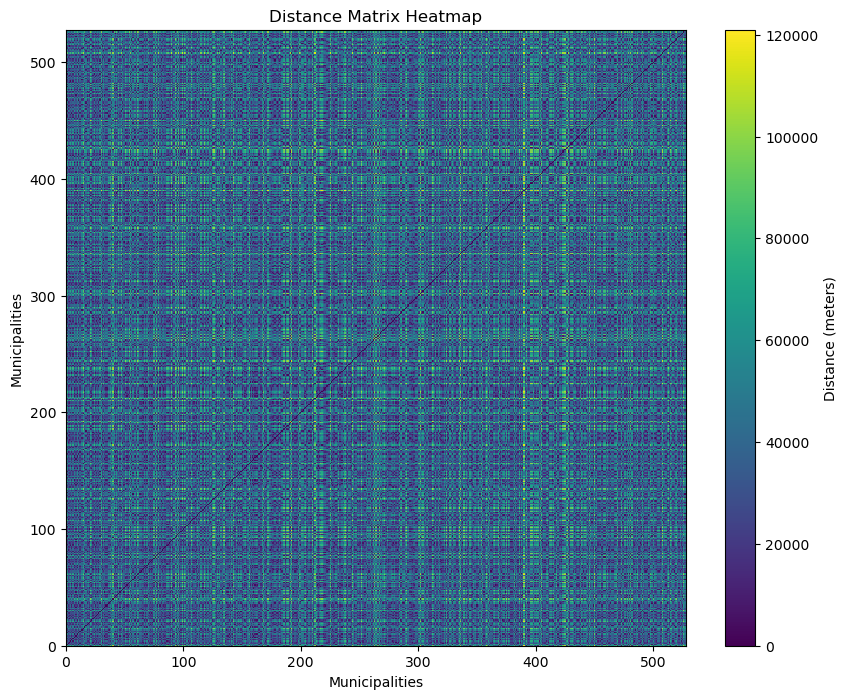

In [67]:
municipalities_gdf = (
    df_iris[df_iris["department_id"] == "14"]
    .dissolve(by="municipality_id")
    .reset_index()
)

centroids = municipalities_gdf["geometry"].centroid
centroids_array = np.array([centroids.x, centroids.y]).T

municipalities = municipalities_gdf["municipality_id"].tolist()
distance_matrix = np.zeros((len(municipalities), len(municipalities)))

for k in range(len(municipalities)):
    distance_matrix[k, :] = norm(centroids_array[k] - centroids_array, axis=1)

plt.figure(figsize=(10, 8))
plt.pcolor(distance_matrix, cmap="viridis")
plt.colorbar(label="Distance (meters)")
plt.title("Distance Matrix Heatmap")
plt.xlabel("Municipalities")
plt.ylabel("Municipalities")
plt.show()

distance_df = pd.DataFrame(
    distance_matrix, index=municipalities, columns=municipalities
)

### Report the resulting flows in a table or plot.


Taille origins_filtered : 528
Taille destinations_filtered : 528
Taille friction_matrix : (528, 528)
       14001  14003  14005  14006  14007  14009  14011  14012  14014  14015  \
14001    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14003    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14005    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14006    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14007    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  14753  14754  14755  14756  14758  14759  14760  14761  14762  \
14001  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14003  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14005  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14006  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14007  ...    0.0    0.0    0.0    0.0 

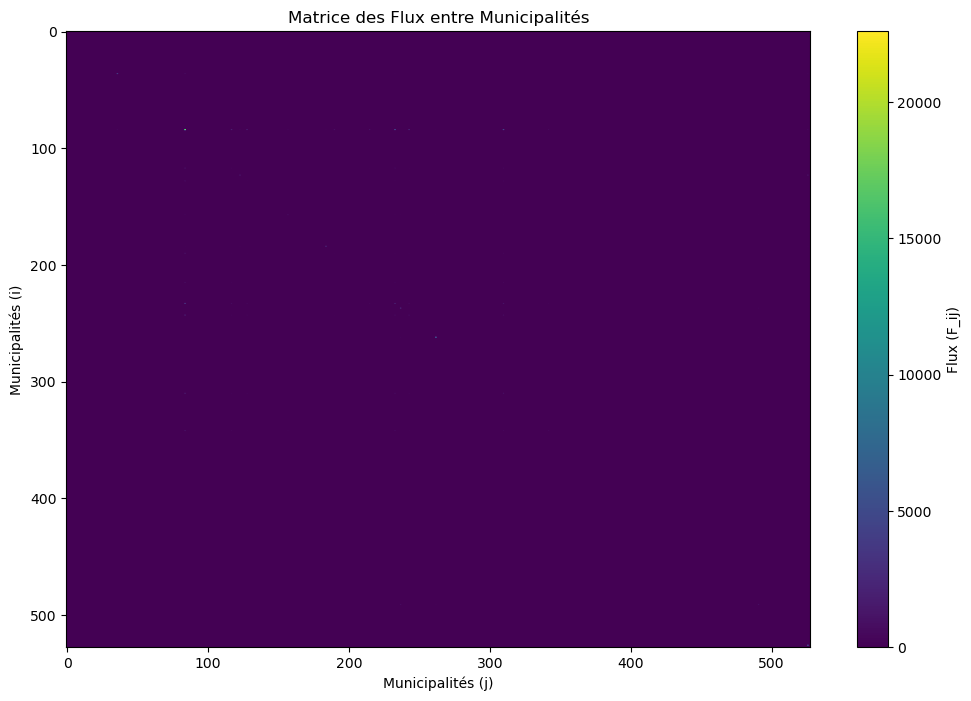

In [68]:
municipalities = municipalities_gdf["municipality_id"].tolist()

origins_filtered = df_population[df_population["municipality_id"].isin(municipalities)]
destinations_filtered = df_employment[
    df_employment["municipality_id"].isin(municipalities)
]

origins_filtered = (
    origins_filtered.set_index("municipality_id")
    .reindex(municipalities)["generated_trips"]
    .fillna(0)
    .values
)
destinations_filtered = (
    destinations_filtered.set_index("municipality_id")
    .reindex(municipalities)["employment"]
    .fillna(0)
    .values
)

alpha = -0.4
beta = -1.1e-4
friction_matrix = np.exp(beta * distance_matrix + alpha)

print(f"Taille origins_filtered : {len(origins_filtered)}")
print(f"Taille destinations_filtered : {len(destinations_filtered)}")
print(f"Taille friction_matrix : {friction_matrix.shape}")

pi = np.ones(len(origins_filtered))
aj = np.ones(len(destinations_filtered))

for _ in range(100):
    pi = origins_filtered / (np.sum(aj * friction_matrix, axis=1) + 1e-9)
    aj = destinations_filtered / (np.sum(pi[:, None] * friction_matrix, axis=0) + 1e-9)

flow_matrix = np.outer(pi, aj) * friction_matrix

flows_df = pd.DataFrame(flow_matrix, index=municipalities, columns=municipalities)

print(flows_df.head())

plt.figure(figsize=(12, 8))
plt.imshow(flow_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Flux (F_ij)")
plt.title("Matrice des Flux entre Municipalités")
plt.xlabel("Municipalités (j)")
plt.ylabel("Municipalités (i)")
plt.show()

### Document the 10 pairs of municipalities with the largest flows and name them.


In [69]:
flows_flat = pd.DataFrame(
    {
        "Origin": np.repeat(municipalities, len(municipalities)),
        "Destination": np.tile(municipalities, len(municipalities)),
        "Flow": flow_matrix.flatten(),
    }
)

top_flows = flows_flat.sort_values(by="Flow", ascending=False).head(10)

if "name" in municipalities_gdf.columns:
    municipality_names = municipalities_gdf.set_index("municipality_id")["name"]
    top_flows["Origin Name"] = top_flows["Origin"].map(municipality_names)
    top_flows["Destination Name"] = top_flows["Destination"].map(municipality_names)
else:
    top_flows["Origin Name"] = top_flows["Origin"]
    top_flows["Destination Name"] = top_flows["Destination"]

fig = px.bar(
    top_flows,
    x="Origin Name",
    y="Flow",
    color="Destination Name",
    title="Top 10 Flows Between Municipalities",
    labels={"Flow": "Flow (F_ij)", "Origin Name": "Origin Municipality"},
    text="Flow",
)
fig.update_layout(xaxis_title="Origin Municipality", yaxis_title="Flow (F_ij)")
fig.show()

## Exercise 3.1: Disaggregation


### Plot the generated trip pairs on a map using a line between origin and destination.


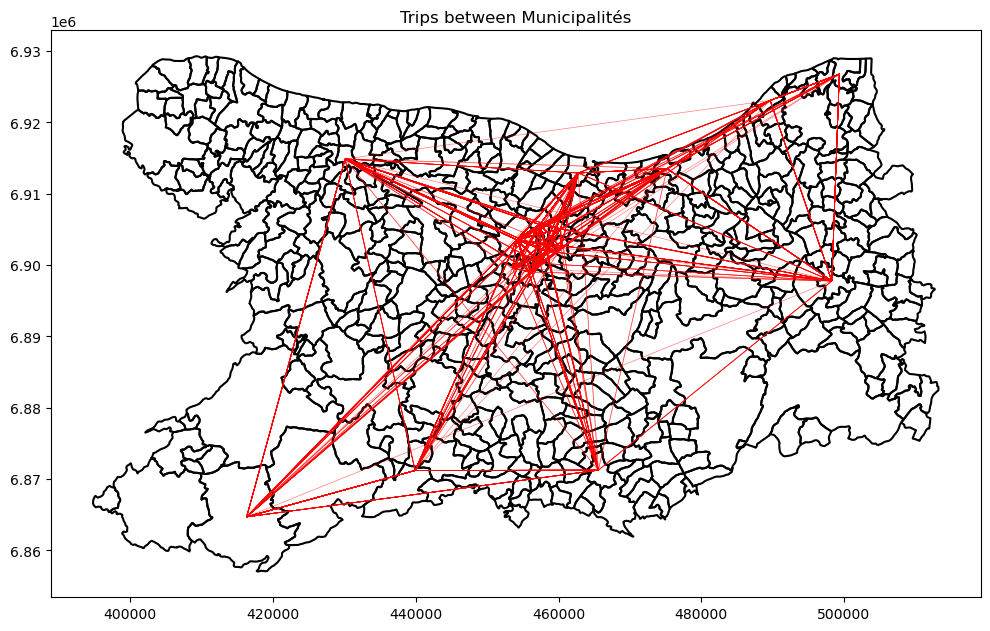

In [70]:
flow_matrix_prob = flow_matrix / flow_matrix.sum()
num_trips = 10000
trips = []

for _ in range(num_trips):
    i, j = np.unravel_index(
        np.random.choice(flow_matrix_prob.size, p=flow_matrix_prob.flatten()),
        flow_matrix_prob.shape,
    )
    origin_geom = municipalities_gdf.loc[
        municipalities_gdf["municipality_id"] == municipalities[i], "geometry"
    ].values[0]
    destination_geom = municipalities_gdf.loc[
        municipalities_gdf["municipality_id"] == municipalities[j], "geometry"
    ].values[0]

    origin_point = origin_geom.representative_point()
    destination_point = destination_geom.representative_point()

    trips.append(LineString([origin_point, destination_point]))

trips_gdf = gpd.GeoDataFrame({"geometry": trips}, crs=municipalities_gdf.crs)

base = municipalities_gdf.boundary.plot(figsize=(12, 8), color="black")
trips_gdf.plot(ax=base, color="red", alpha=0.5, linewidth=0.5)
plt.title("Trips between Municipalités")
plt.show()

### Plot the distribution of the departure times as a histogram or CDF.


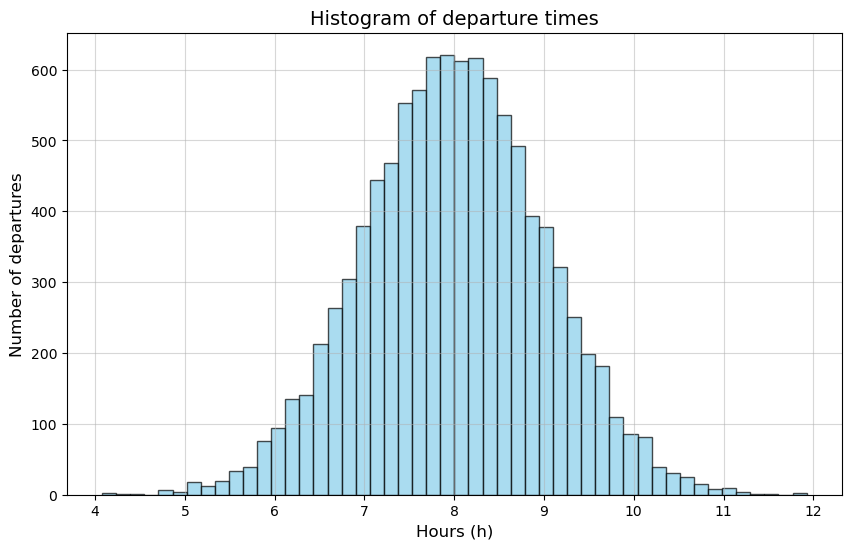

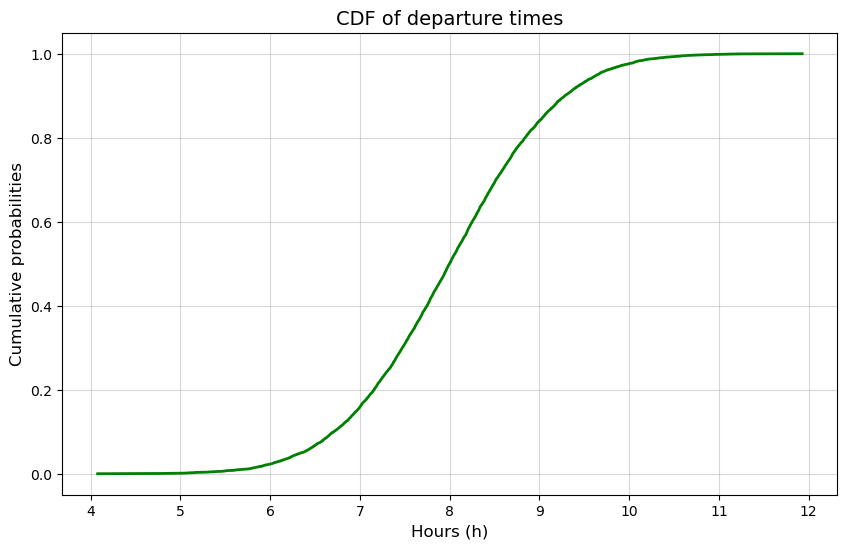

In [71]:
np.random.seed(42)
num_trips = 10000
departure_times = np.maximum(
    0, np.random.normal(loc=8 * 3600, scale=3600, size=num_trips)
)

plt.figure(figsize=(10, 6))
plt.hist(departure_times / 3600, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Histogram of departure times", fontsize=14)
plt.xlabel("Hours (h)", fontsize=12)
plt.ylabel("Number of departures", fontsize=12)
plt.grid(alpha=0.5)
plt.show()

sorted_times = np.sort(departure_times / 3600)
cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)

plt.figure(figsize=(10, 6))
plt.plot(sorted_times, cdf, color="green", lw=2)
plt.title("CDF of departure times", fontsize=14)
plt.xlabel("Hours (h)", fontsize=12)
plt.ylabel("Cumulative probabilities", fontsize=12)
plt.grid(alpha=0.5)
plt.show()

## Exercise 3.2: Routing


- Download OpenStreetMap on Geofabrik at http://download.geofabrik.de/europe/france/basse-normandie-latest.osm.pbf
- Downloaded Osmosis at https://github.com/openstreetmap/osmosis/releases/tag/0.49.2


In [72]:
import osmnx as ox
import networkx as nx

### Convert a road network from OpenStreetMap data such that you can use it for routing. Plot the network on a map of your study area.


In [73]:
#!wget http://download.geofabrik.de/europe/france/basse-normandie-latest.osm.pbf

In [74]:
#!osmium extract basse-normandie-latest.osm.pbf -p perimeter.geojson --overwrite -o cut.osm.pbf
#!osmium tags-filter -o calvados_roads.osm.pbf cut.osm.pbf w/highway

In [75]:
# Define the input file that shall be converted
study_area_path = "calvados_road_network.gpkg"

# Define the name of the output file in poly format
output_path = "calvados.poly"

In [76]:
df = gpd.read_file(study_area_path)
df = df.to_crs("EPSG:4326")

df["aggregate"] = 0
area = df.dissolve(by="aggregate")["geometry"].values[0]

if not hasattr(area, "exterior"):
    print("Selected area is not connected -> Using convex hull.")
    area = area.convex_hull

data = []
data.append("polyfile")
data.append("polygon")

for coordinate in area.exterior.coords:
    data.append("    %e    %e" % coordinate)

data.append("END")
data.append("END")

with open(output_path, "w+") as f:
    f.write("\n".join(data))

DataSourceError: calvados_road_network.gpkg: No such file or directory

In [75]:
# Set the path where osmosis is
osmosis_path = "osmosis-0.49.2\\bin\\osmosis"

In [76]:
# Test if osmosis can be called from the notebook (it may be needed to add JAVA_HOME to the path variables)
!{osmosis_path} -v

Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Searching for JPF plugins.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the core plugin.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the extension plugins.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Building tasks.
Jan 10, 2025 4:24:40 PM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Connecting tasks.
Jan 10, 2025 4:24:

In [77]:
!{osmosis_path} --read-pbf basse-normandie-latest.osm.pbf \
    --tag-filter accept-ways highway=* \
    --bounding-polygon file=calvados.poly completeWays=yes \
    --used-node --write-xml calvados.osm.xml

Jan 10, 2025 4:29:13 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Jan 10, 2025 4:29:13 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Jan 10, 2025 4:29:13 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Launching pipeline execution.
Jan 10, 2025 4:29:13 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline executing, waiting for completion.
Jan 10, 2025 4:31:03 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline complete.
Jan 10, 2025 4:31:03 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Total execution time: 110265 milliseconds.


Way 1: Read from xml file


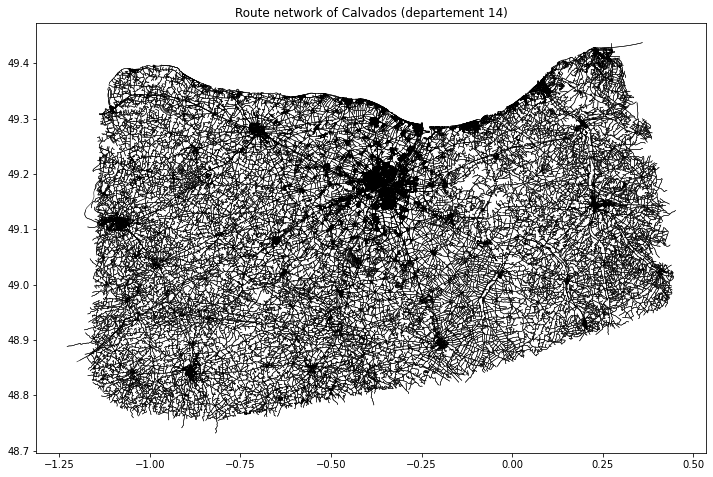

In [82]:
graph = ox.graph_from_xml("calvados.osm.xml")
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, color="black")
plt.title("Route network of Calvados (departement 14)")
plt.show()

Way 2: Get excally Calvados region


In [ ]:
# place_name = "Calvados, France"

# graph = ox.graph_from_place(place_name, network_type="drive")

# nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

# fig, ax = plt.subplots(figsize=(12, 12))
# edges.plot(ax=ax, linewidth=0.5, color="black")
# plt.title("Route network of Calvados (departement 14)")
# plt.show()

# edges.to_file("calvados_road_network.gpkg", driver="GPKG")

### Perform a routing of all generated trips on the network. Count the number of trips traversing each edge of your network and indicate the flow on each link on a map.


In [122]:
trips_gdf["origin_geometry"] = trips_gdf.sample_points(1)
trips_gdf["destination_geometry"] = trips_gdf.sample_points(1)

In [123]:
trips_gdf

,geometry,origin_geometry,destination_geometry
0,"LINESTRING (454160.09 6903511.65, 454160.09 69...",POINT (454160.09 6903511.65),POINT (454160.09 6903511.65)
1,"LINESTRING (454160.09 6903511.65, 454160.09 69...",POINT (454160.09 6903511.65),POINT (454160.09 6903511.65)
2,"LINESTRING (454160.09 6903511.65, 454160.09 69...",POINT (454160.09 6903511.65),POINT (454160.09 6903511.65)
3,"LINESTRING (456240.067 6899003.925, 457386.736...",POINT (456996.028 6903393.11),POINT (456712.532 6901747.106)
4,"LINESTRING (456240.067 6899003.925, 454160.09 ...",POINT (455598.951 6900393.352),POINT (455331.46 6900973.058)
...,...,...,...
9995,"LINESTRING (454160.09 6903511.65, 454160.09 69...",POINT (454160.09 6903511.65),POINT (454160.09 6903511.65)
9996,"LINESTRING (439902.134 6871192.15, 439902.134 ...",POINT (439902.134 6871192.15),POINT (439902.134 6871192.15)
9997,"LINESTRING (454160.09 6903511.65, 454160.09 69...",POINT (454160.09 6903511.65),POINT (454160.09 6903511.65)
9998,"LINESTRING (454160.09 6903511.65, 453569.034 6...",POINT (453604.922 6899756.265),POINT (453762.356 6900821.209)


In [119]:
df_edges = ox.graph_to_gdfs(graph, edges=True, nodes=False)
df_edges = df_edges.reset_index()[["u", "v", "highway", "geometry"]]
df_edges["highway"] = df_edges["highway"].astype(str)

In [115]:
# trips_gdf["origin_geometry"] = trips_gdf["geometry"].apply(lambda x: x.coords[0])
# type(trips_gdf["geometry"].apply(lambda x: x.coords[1]))

pandas.core.series.Series

In [124]:
# add origin_node column to our data frame
geometry = trips_gdf["origin_geometry"].to_crs("EPSG:4326")
trips_gdf["origin_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

# add destination_node column to our data frame
geometry = trips_gdf["destination_geometry"].to_crs("EPSG:4326")
trips_gdf["destination_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

In [ ]:
# Perform the routing
N = len(trips_gdf)
routes = ox.shortest_path(
    graph, trips_gdf["origin_node"].iloc[:N], trips_gdf["destination_node"].iloc[:N]
)

In [132]:
# Count the number of trips in each edge of the network
df_count = {"u": [], "v": []}

for route in routes:
    for k in range(1, len(route)):
        df_count["u"].append(route[k - 1])
        df_count["v"].append(route[k])

df_count = pd.DataFrame(df_count)
df_count = df_count.groupby(["u", "v"]).size().reset_index(name="count")

df_count.sort_values(by="count", ascending=False).head()

,u,v,count
847,26290401,11264181728,190
266,26019466,26019468,184
25995,5295846914,26019466,183
265,26019462,5295846914,183
14519,1748526269,105457329,179


In [ ]:
df_count = pd.merge(df_edges, df_count, on=["u", "v"], how="left")
df_count["count"] = df_count["count"].fillna(0.0)
df_count

,u,v,highway,geometry,count
0,16825422,16825428,trunk,"LINESTRING (-0.41928 49.1909, -0.41861 49.1910...",0.0
1,16825428,107476481,trunk,"LINESTRING (-0.39886 49.19572, -0.39813 49.195...",0.0
2,16825428,1269773681,trunk_link,"LINESTRING (-0.39886 49.19572, -0.39868 49.195...",0.0
3,16825435,26001012,trunk,"LINESTRING (-0.37406 49.19814, -0.37318 49.198...",0.0
4,16825440,16825442,trunk,"LINESTRING (-0.35694 49.20269, -0.35641 49.202...",0.0
...,...,...,...,...,...
573212,12487052194,1981769054,"['track', 'service']","LINESTRING (-0.6595 48.92279, -0.66171 48.9232...",0.0
573213,12487056502,5284215976,unclassified,"LINESTRING (-0.68226 48.89668, -0.68211 48.897...",0.0
573214,12487056502,5284216134,unclassified,"LINESTRING (-0.68226 48.89668, -0.68227 48.896...",0.0
573215,12487056502,12487056506,service,"LINESTRING (-0.68226 48.89668, -0.68242 48.896...",0.0


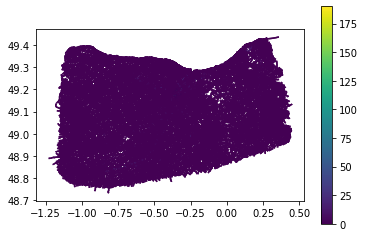

In [ ]:
df_count.plot("count", legend=True)
df_count.to_file("count.gpkg")